# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.integrate import odeint
import lmfit
import warnings
warnings.filterwarnings('ignore')

/Users/ribarragi/miniconda3/envs/dabp/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Data

In [2]:
url = 'https://raw.githubusercontent.com/mahrukh-k/DABP/main/Daily%20Cases%20USA.csv'
cases_usapd = pd.read_csv(url)
cases_usapd.columns

Index(['epi_date_V2', 'Cases', '7-Day Average', 'Cumulative Cases', 'AsOf'], dtype='object')

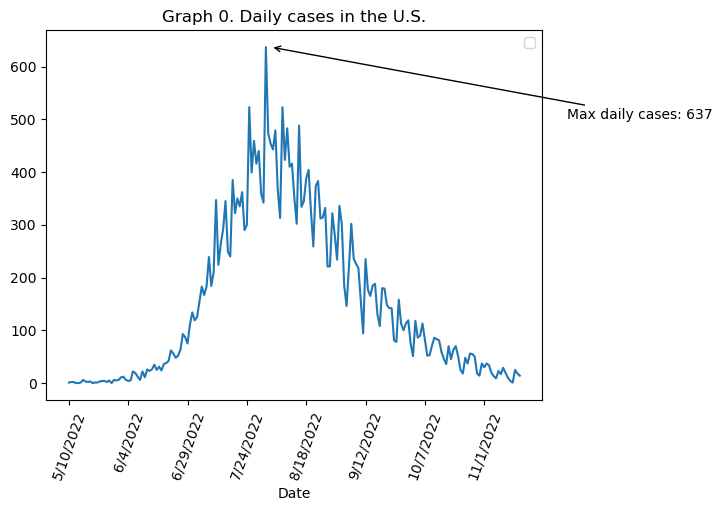

In [3]:
cases_usapd.plot(x = 'epi_date_V2', y = 'Cases', rot=70) # Daily cases: 05/2022 - 11/2022
plt.xlabel('Date')
# plt.xkcd()
plt.title('Graph 0. Daily cases in the U.S.')
plt.annotate('Max daily cases: 637', xy = (85, 637), xytext=(210, 500), arrowprops=dict(color='black', arrowstyle='->'))
plt.legend('')
plt.show()

In [4]:
cases_usapd['Cases'].max()

637

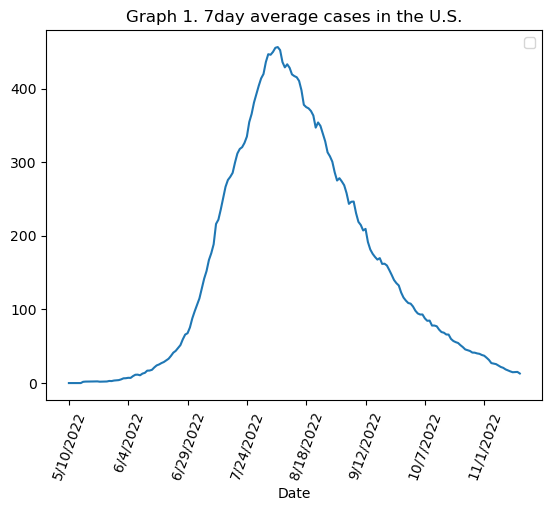

In [5]:
cases_usapd.plot(x = 'epi_date_V2', y = '7-Day Average', rot=70) # Daily cases: 05/2022 - 11/2022
plt.xlabel('Date')
# plt.xkcd()
plt.title('Graph 1. 7day average cases in the U.S.')
plt.legend('')
plt.show()

In [6]:
cases_usapd['epi_date_V2'][cases_usapd['Cases'] == cases_usapd['Cases'].max()].iloc[0]

'8/1/2022'

In [7]:
cases_usapd['Cumulative Cases'].max()

28995

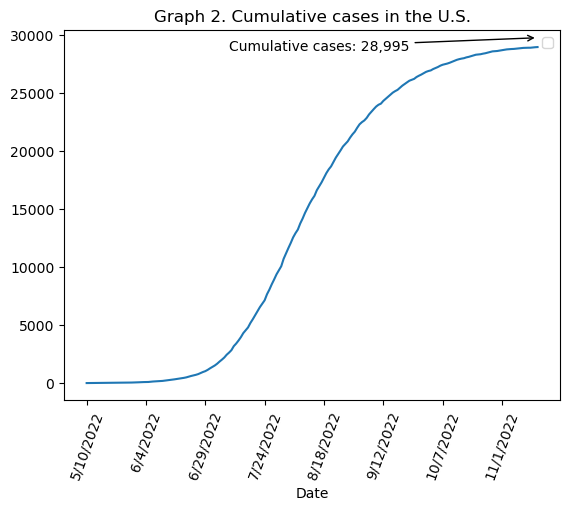

In [8]:
import datetime as dt
cases_usapd.plot(x = 'epi_date_V2', y = 'Cumulative Cases', rot=70) # Daily cases: 05/2022 - 11/2022
plt.xlabel('Date')
# plt.xkcd()
plt.annotate('Cumulative cases: 28,995', xy = (190, 29800), xytext=(60, 28700), arrowprops=dict(color='black', arrowstyle='->'))
plt.title('Graph 2. Cumulative cases in the U.S.')
plt.legend('')
plt.show()

In [9]:
# # Option 1, use daily cases for the fitting
cases_usa = np.array(cases_usapd['7-Day Average'])
# cases_usa = np.array(cases_usapd['Cases']

# Model

## Parameters

In [10]:
# PARAMETERS
gamma = (1/18)    # this is 0.0555
theta = 0.005/100
q = 0.02
vacc = 1000000/(300000000 * 6 * 30)  # this is 0.0000185
N_total = 144321749
N = 144321749

In [11]:
# SIR MODEL
def deriv_dynamic(y, t, beta, gamma, theta, q, vacc, N):
    S, I, R, D, I2 = y
    dSdt = -beta(t) * (1 - q) * S * I / N - vacc * S
    dIdt = beta(t) * (1 - q) * S * I / N - (gamma + theta) * I
    dRdt = gamma * I + vacc * S 
    dDdt = theta * I
    # I2 will be the cumulative cases curve
    dI2dt = beta(t) * (1 - q) * S * I / N  
    return dSdt, dIdt, dRdt, dDdt, dI2dt

In [12]:
# Defining the dynamic R0 and the model
# In developing part of this code, we used part of the class SIR Extensions code
def logistic_R_0(t, R_0_start, k, x0, R_0_end): 
  #x0 = lockdown date, k = how fast R0 changes
  return (R_0_start-R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end

# Defining our model
def Model(days, N_total, R_0_start, k, x0, R_0_end):
    def beta(t):
        return logistic_R_0(t, R_0_start, k, x0, R_0_end) * gamma 

    # set all initial conditions: S0, I0, R0, D0, I20
    y0 = (N) - 5, 5, 0, 0, 5 # we start with five onfected only, 
    t = np.linspace(0, days-1, days)
    ret = odeint(deriv_dynamic, y0, t, args=(beta, gamma, theta, q, vacc, N))
    S, I, R, D, I2 = ret.T
    R_0_over_time = [beta(i)/gamma for i in range(len(t))]

    return t, S, I, R, D, I2, R_0_over_time


# Fitting

In [16]:
# Use cumulative cases for the fitting
cases_usa = np.array(cases_usapd['Cumulative Cases'])

# In developing part of this code, we used some of the ideas from here: 
# https://towardsdatascience.com/infectious-disease-modelling-fit-your-model-to-coronavirus-data-2568e672dbc7
def fitter(x, R_0_start, k, x0, R_0_end):
    ret = Model(days, N_total, R_0_start, k, x0, R_0_end)
    return ret[5] # I2 curve

outbreak_day = 30   # Lets say the outbreak starts on day 10
data = cases_usa  # data
days = outbreak_day + len(data)
y_data = np.concatenate((np.zeros(outbreak_day), data))
x_data = np.linspace(0, days - 1, days, dtype=int) 
    
params_init = {"R_0_start": (0.1, -5.000001, 10.0), "k": (0.1, -5.01, 8.0), 
                       "x0": (10, 0, 150), "R_0_end": (0.1, -5.00001, 5)}  
                       # {parameter: (initial guess, minimum value, max value)}
mod = lmfit.Model(fitter)
for j, (init, mini, maxi) in params_init.items():
    mod.set_param_hint(str(j), value=init, min=mini, max=maxi, vary=True)
params = mod.make_params()
fit_method = "leastsq"
result = mod.fit(y_data, params, method="least_squares", x=x_data)

In [17]:
result.best_values # These are the best parameters

{'R_0_start': 0.5582598820308351,
 'k': -0.09220744802788897,
 'x0': 120.53097034035211,
 'R_0_end': 2.210245752861503}

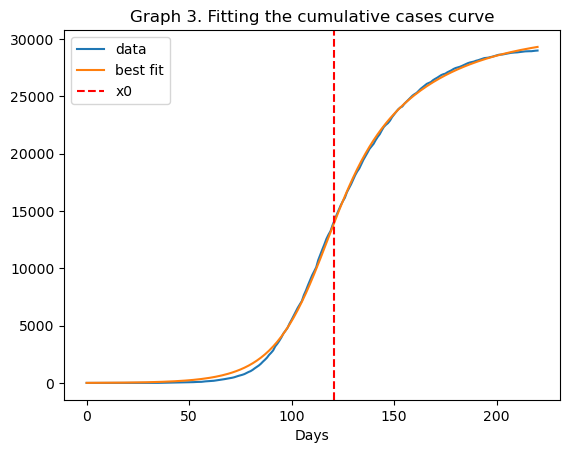

In [18]:
result.plot_fit(datafmt="-")
plt.axvline(x = result.best_values['x0'], linestyle = '--', color = 'r', label = 'x0')
plt.title("Graph 3. Fitting the cumulative cases curve")
# plt.annotate('Magic!', xy = (60, 10800), xytext=(60, 10800))
plt.xlabel('Days')
plt.ylabel('')
plt.legend()
plt.show()

In [19]:
t_fit, S_fit, I_fit, R_fit, D_fit, I2_fit, R0_fit = Model(250, N_total, **result.best_values)

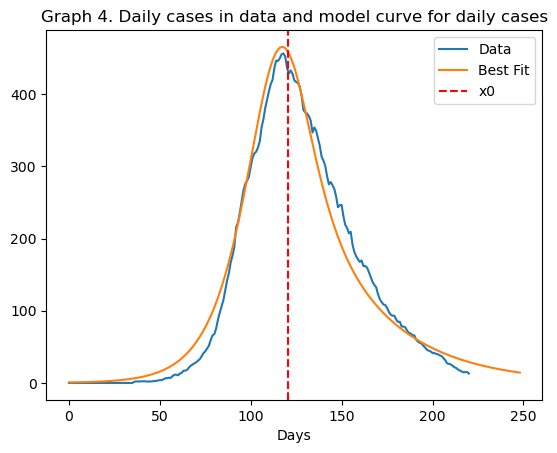

In [20]:
plt.plot(np.concatenate((np.zeros(outbreak_day) , np.array(cases_usapd['7-Day Average']))), label = 'Data')
plt.plot(np.diff(I2_fit), label = 'Best Fit')
plt.legend()
plt.xlabel('Days')
plt.title('Graph 4. Daily cases in data and model curve for daily cases')
plt.axvline(x = result.best_values['x0'], linestyle = '--', color = 'r', label = 'x0')
plt.legend()
plt.show()

# cases_usapd['7-Day Average'].plot(label = 'Data')

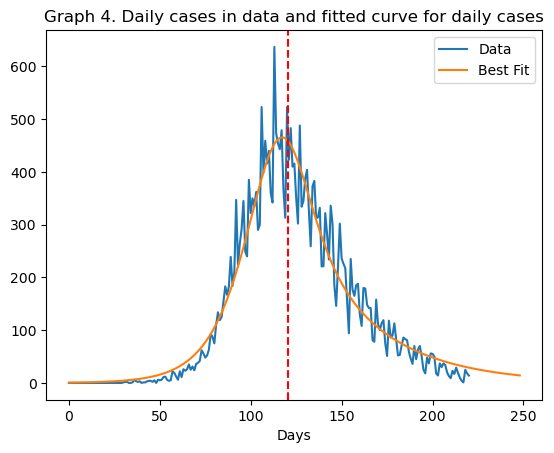

In [24]:
plt.plot(np.concatenate((np.zeros(outbreak_day) , np.array(cases_usapd['Cases']))), label = 'Data')
plt.plot(np.diff(I2_fit), label = 'Best Fit')
plt.legend()
plt.xlabel('Days')
plt.title('Graph 4. Daily cases in data and fitted curve for daily cases')
plt.axvline(x = result.best_values['x0'], linestyle = '--', color = 'r', label = 'x0')
plt.show()

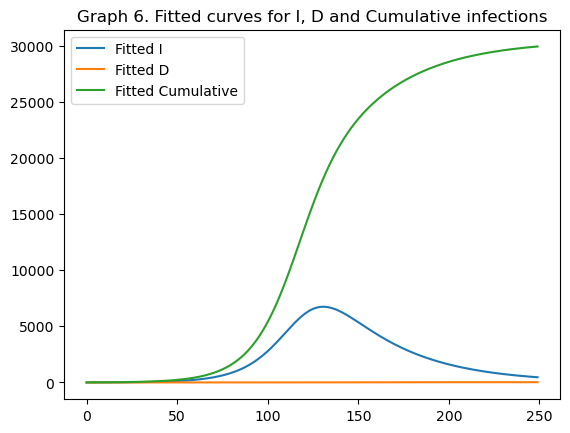

In [25]:
plt.plot(list(I_fit), label = 'Fitted I') 
plt.plot(list(D_fit), label = 'Fitted D')
plt.plot(list(I2_fit), label = 'Fitted Cumulative')
plt.title('Graph 6. Fitted curves for I, D and Cumulative infections')
plt.legend()

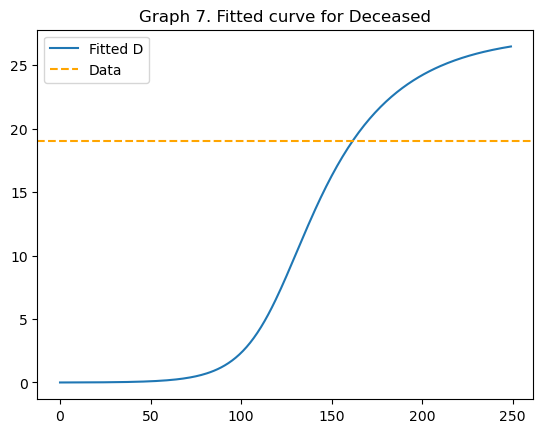

In [31]:
plt.plot(list(D_fit), label = 'Fitted D')
plt.title('Graph 7. Fitted curve for Deceased')
plt.axhline(y = 19, linestyle = '--', color = 'orange', label = 'Data')
plt.legend()

In [78]:
D_fit[-5:]

array([209.77405333, 209.97473774, 210.1703878 , 210.36112967,
       210.54708638])

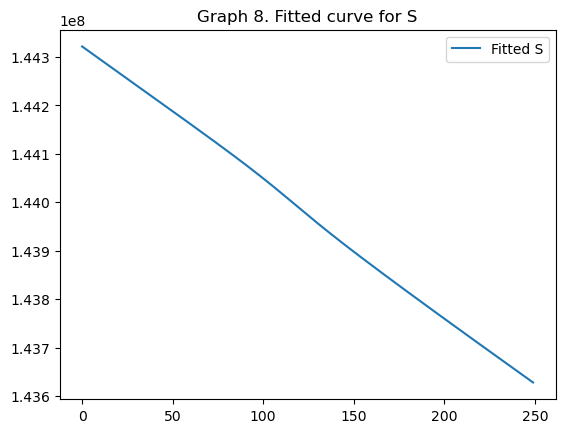

In [79]:
plt.plot(list(S_fit), label = 'Fitted S') 
plt.title('Graph 8. Fitted curve for S')
plt.legend()

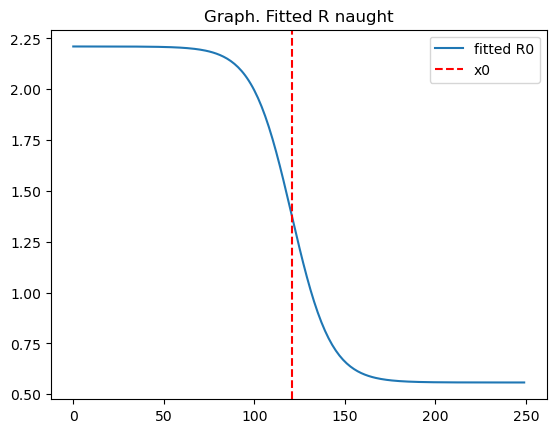

In [32]:
plt.plot(list(R0_fit), label = 'fitted R0')
plt.axvline(x = result.best_values['x0'], linestyle = '--', color = 'r', label = 'x0')
plt.title('Graph. Fitted R naught')
# plt.xlim(-200, 400)
# plt.ylim(0, 3)
plt.legend()
plt.show()

## **Modeling different scenarios: changes in q (isolation rate)**

In [44]:
# PARAMETERS
gamma_adj = 1/18 # (1/14)
theta_adj = 0.005/100
q_adj = 0.02 # Original
vacc_adj = (1000000/(300000000 * 6 * 30)) * 1.2
N_total_adj = 144321749
N_adj = 144321749

R_0_start_adj = result.best_values['R_0_start']
k_adj = result.best_values['k']
x0_adj = result.best_values['x0']
R_0_end_adj = result.best_values['R_0_end']

In [45]:
# model fully specified
def deriv_dynamic_adj(y, t, beta, gamma, theta, q, vacc, N):
    S, I, R, D, I2 = y
    dSdt = -beta(t) * (1 - q) * S * I / N - vacc * S
    dIdt = beta(t) * (1 - q) * S * I / N - (gamma + theta) * I
    dRdt = gamma * I + vacc * S 
    dDdt = theta * I
    dI2dt = beta(t) * (1 - q) * S * I / N  # I2 will be the cumulative cases curve
    return dSdt, dIdt, dRdt, dDdt, dI2dt

In [46]:
# Defining the dynamic R0 and the model
# In developing part of this code, we used part of the class SIR Extensions code
def logistic_R_0(t, R_0_start, k, x0, R_0_end): 
  #x0 = lockdown date, k = how fast R0 changes
  return (R_0_start-R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end

# Defining our model
def Model_adj(days, N_total, R_0_start, k, x0, R_0_end, q_adj):
    def beta(t):
        return logistic_R_0(t, R_0_start, k, x0, R_0_end) * gamma 

    # set all initial conditions: S0, I0, R0, D0, I20
    y0 = (N) - 5, 5, 0, 0, 5 # we start with five onfected only, 
    t = np.linspace(0, days-1, days)
    ret = odeint(deriv_dynamic_adj, y0, t, args=(beta, gamma_adj, theta_adj, q_adj, vacc_adj, N_adj))
    S, I, R, D, I2 = ret.T
    R_0_over_time = [beta(i)/gamma for i in range(len(t))]

    return t, S, I, R, D, I2, R_0_over_time

In [47]:
t_fit_adj, S_fit_adj, I_fit_adj, R_fit_adj, D_fit_adj, I2_fit_adj, R0_fit_adj = Model_adj(250, N_total, R_0_start_adj, k_adj, x0_adj, R_0_end_adj, q)

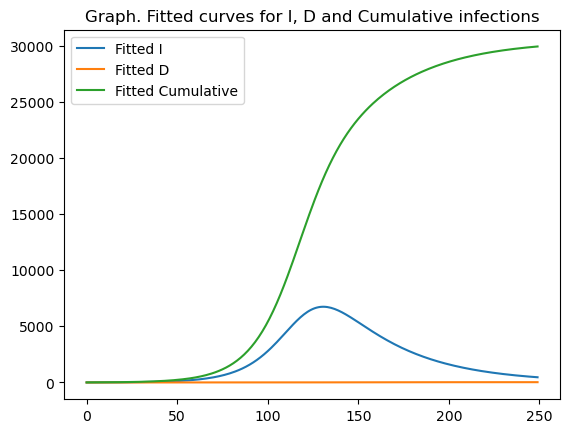

In [48]:
# Original
plt.plot(list(I_fit), label = 'Fitted I')
plt.plot(list(D_fit), label = 'Fitted D')
plt.plot(list(I2_fit), label = 'Fitted Cumulative')
plt.title('Graph. Fitted curves for I, D and Cumulative infections')
plt.legend()
# plt.xlim(0, 60)
# plt.ylim(0, 100)

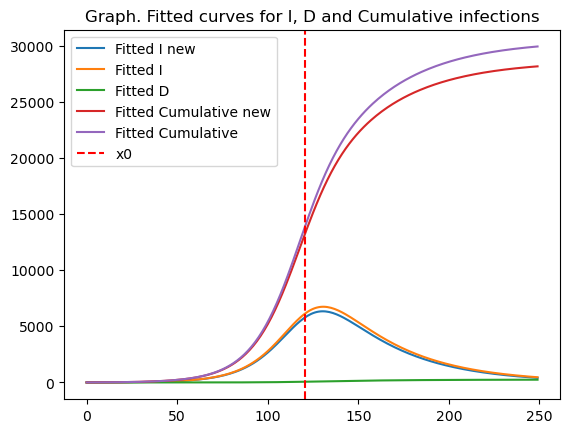

In [40]:
# Tweaked
plt.plot(list(I_fit_adj), label = 'Fitted I new') 
plt.plot(list(I_fit), label = 'Fitted I') 

plt.plot(list(D_fit_adj), label = 'Fitted D')
plt.plot(list(I2_fit_adj), label = 'Fitted Cumulative new')
plt.plot(list(I2_fit), label = 'Fitted Cumulative')

plt.axvline(x = result.best_values['x0'], linestyle = '--', color = 'r', label = 'x0')
plt.title('Graph. Fitted curves for I, D and Cumulative infections')
plt.legend()

In [41]:
# # Create figure
# plt.figure(figsize = (14, 6))

# # Plot the first four arrays on the left side
# ax1 = plt.subplot(1, 3, 1)
# plt.plot(list(I_fit_adj), color = 'red', label = 'App', linestyle = '--')
# plt.plot(list(I_fit), color = 'red', label = 'Baseline (no app)')
# plt.ylabel('Value')
# plt.xlabel('Time')
# plt.title('Daily infections')
# plt.legend()

# # Plot the last four arrays on the right side
# # plt.subplot(1, 2, 2, sharey = ax1)
# plt.subplot(1, 3, 2)
# plt.plot(list(I2_fit_adj), color = 'blue', label = 'App', linestyle = '--')
# plt.plot(list(I2_fit), color = 'blue', label = 'Baseline (no app)')
# plt.ylabel('Value')
# plt.xlabel('Time')
# plt.title('Cumulative infections')
# plt.legend()

# plt.subplot(1, 3, 3)
# plt.plot(list(D_fit_adj), color = 'purple', label = 'App', linestyle = '--')
# plt.plot(list(D_fit), color = 'purple', label = 'Baseline (no app)')
# plt.ylabel('Value')
# plt.xlabel('Time')
# plt.title('Deceased')
# plt.legend()

# plt.tight_layout()

# plt.show()

In [49]:
def create_graphs(q):
  t_fit_adj, S_fit_adj, I_fit_adj, R_fit_adj, D_fit_adj, I2_fit_adj, R0_fit_adj = Model_adj(250, N_total, R_0_start_adj, k_adj, x0_adj, R_0_end_adj, q)
  # Create figure
  plt.figure(figsize = (14, 6))

  # Plot the first four arrays on the left side
  ax1 = plt.subplot(2, 2, 1)
  plt.plot(list(I_fit_adj), color = 'red', label = 'App', linestyle = '--')
  plt.plot(list(I_fit), color = 'red', label = 'Baseline (no app)')
  plt.ylabel('Value')
  plt.xlabel('Time')
  plt.title(f'Daily infections, q = {q}')
  plt.legend()

  # Plot the last four arrays on the right side
  # plt.subplot(1, 2, 2, sharey = ax1)
  plt.subplot(2, 2, 2)
  plt.plot(list(I2_fit_adj), color = 'blue', label = 'App', linestyle = '--')
  plt.plot(list(I2_fit), color = 'blue', label = 'Baseline (no app)')
  plt.ylabel('Value')
  plt.xlabel('Time')
  plt.title(f'Cumulative infections, q = {q}')
  plt.legend()

  plt.subplot(2, 2, 3)
  plt.plot(list(D_fit_adj), color = 'purple', label = 'App', linestyle = '--')
  plt.plot(list(D_fit), color = 'purple', label = 'Baseline (no app)')
  plt.ylabel('Value')
  plt.xlabel('Time')
  plt.title(f'Deceased, q = {q}')
  plt.legend()

  plt.subplot(2, 2, 4)
  plt.plot(list(R0_fit_adj), color = 'green', label = 'App', linestyle = '--')
  plt.plot(list(R0_fit), color = 'green', label = 'Baseline (no app)')
  plt.ylabel('Value')
  plt.xlabel('Time')
  plt.title(f'R naught, q = {q}')
  plt.legend()

  plt.tight_layout()
  plt.show()
  

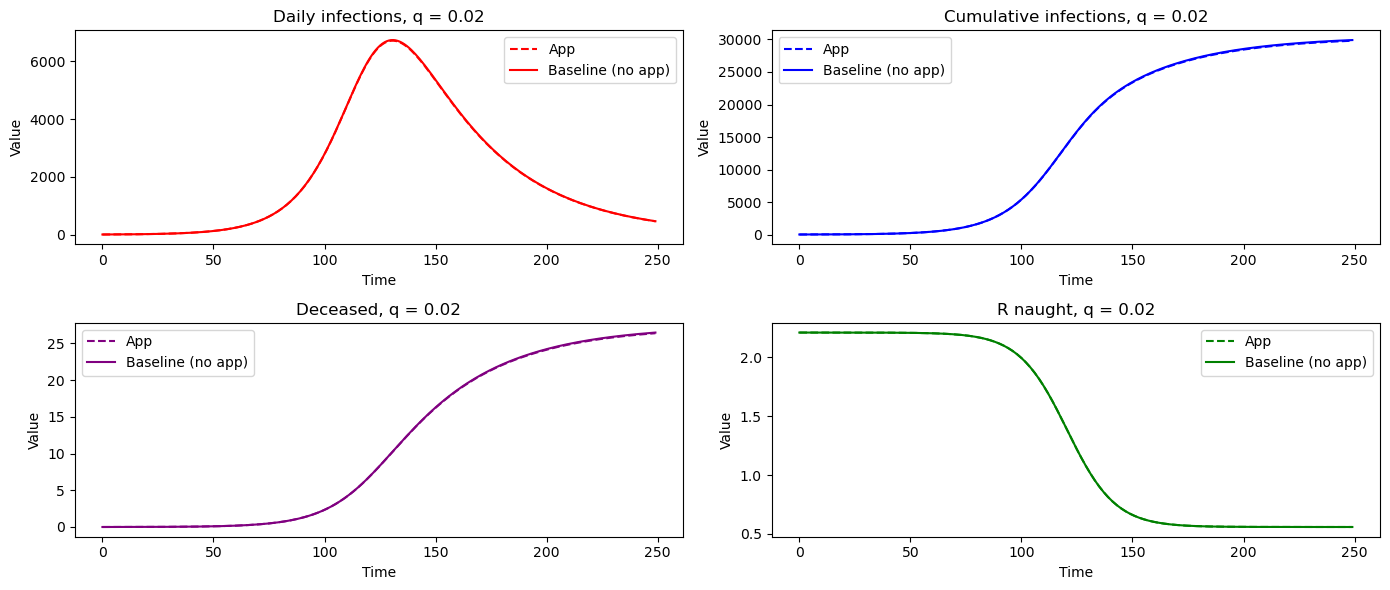

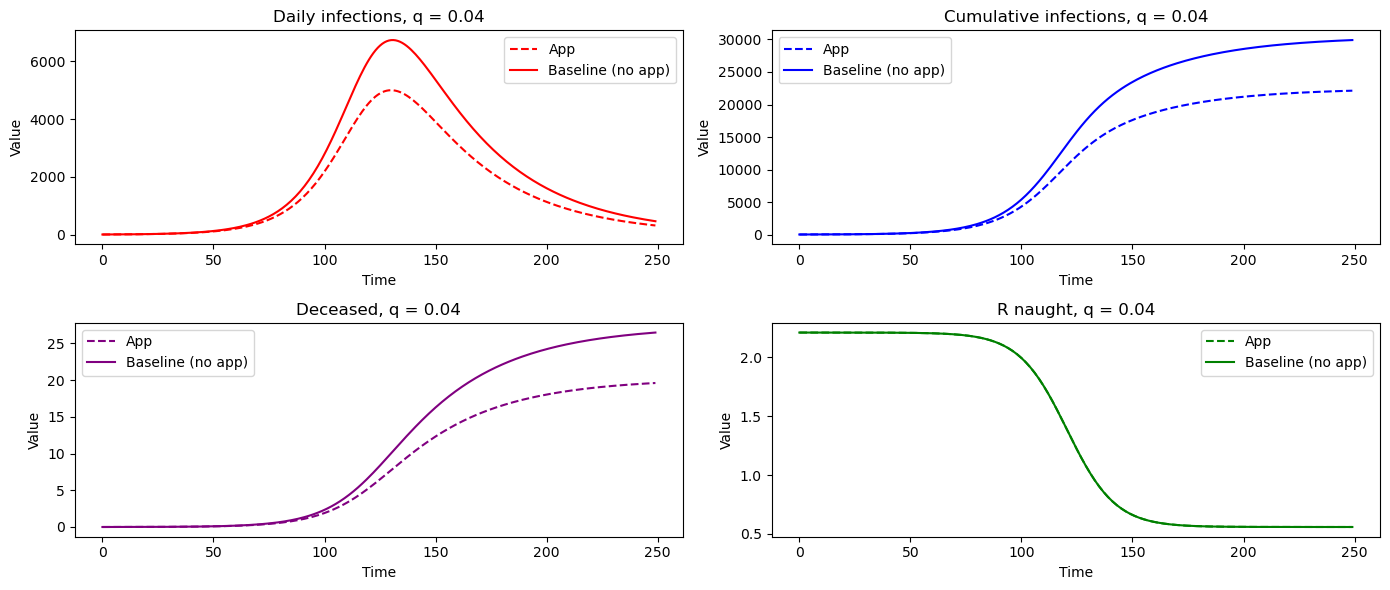

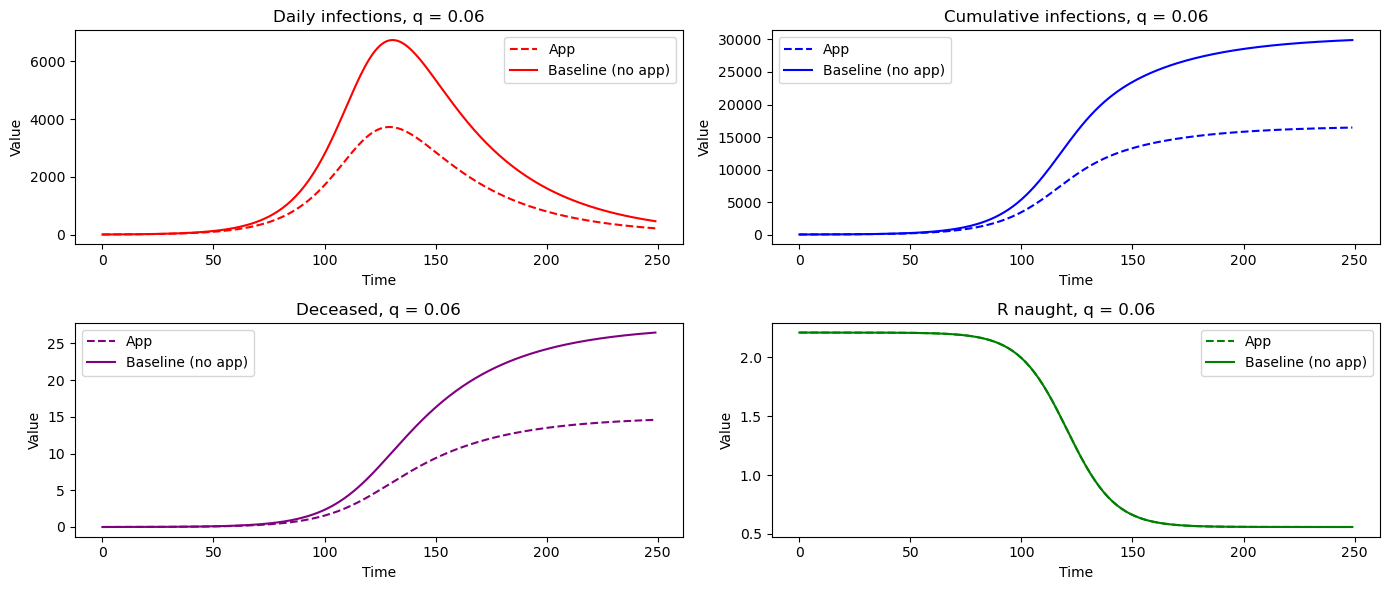

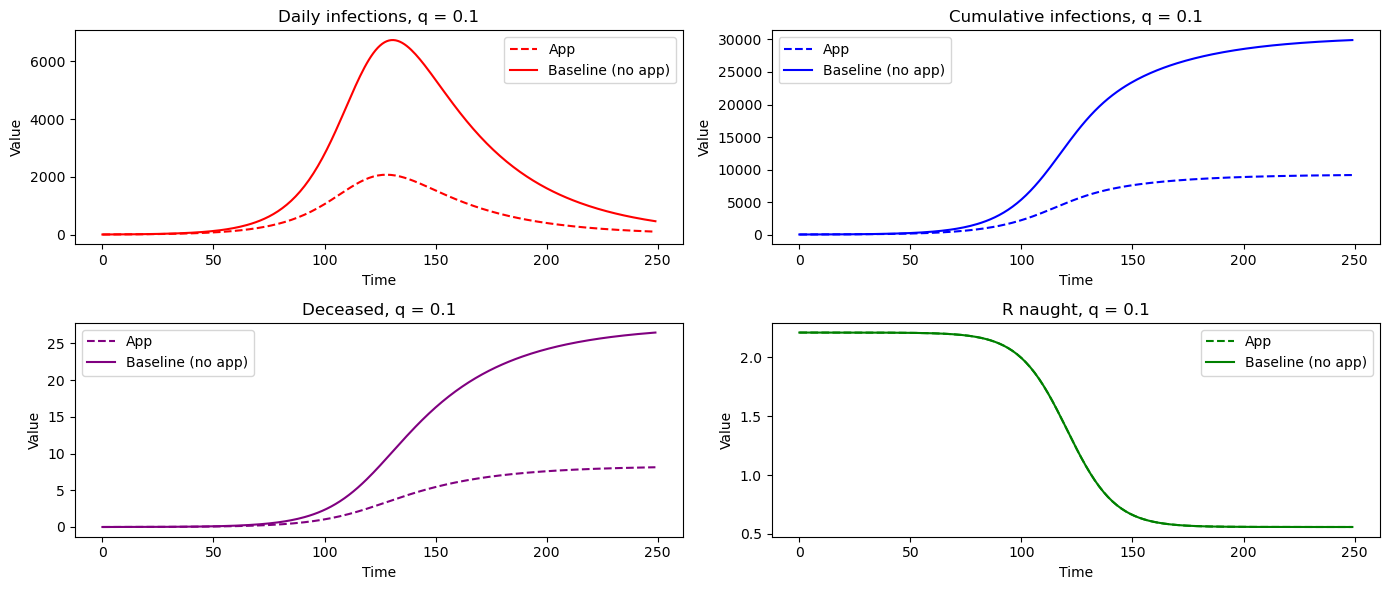

In [51]:
for i in [0.02, 0.04, 0.06, 0.1]:
  create_graphs(i)
